In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Set default sizes for figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 15) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 15) # fontsize of the tick labels
plt.rc("ytick", labelsize = 15) # fontsize of the tick labels
plt.rc("legend", fontsize = 15) # legend fontsize

# Analysis

In [3]:
PROJECT_ROOT = "./RESULTS/Review"

## Yemen data managed in order to change length time-series

In [4]:
# Load corresponding simulations (hyper-parameter tuning + forecasting).
COUNTRY = "Yemen"
DATES = ["2018-07-02 (2018-08-14)", "2018-12-14", "2019-04-14", "2019-08-14", "2019-12-14"]
DATES_NAMES = ["2018-08-14", "2018-12-14", "2019-04-14", "2019-08-14", "2019-12-14"]

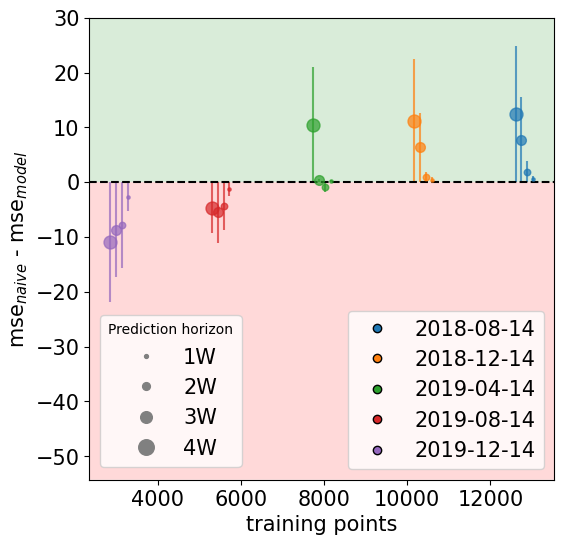

In [5]:
fig, axs = plt.subplots(figsize = (6, 6))

for i, date in enumerate(DATES):
    # Load training shapes.
    training_shape = pd.read_csv(f"{PROJECT_ROOT}/{COUNTRY}/{date}/standard/out_test/training_shapes.csv", header = [0,1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)
    # Load mse loss based on prediction horizons.
    loss_h = pd.read_csv(f"{PROJECT_ROOT}/{COUNTRY}/{date}/standard/out_test/loss_h.csv", index_col = [0, 1], header = [0, 1]).droplevel(0, axis = 0)
        
    results = loss_h.stack(["Split"])
    # For each split get difference between 'mse_naive' and 'mse_model'.
    results["diff"] =  results["mse_naive"] - results["mse_model"]
    results = results.unstack().reorder_levels(["Split", "Type"], axis = 1).xs("diff", axis = 1, level = 1, drop_level = False)
    # Concatenate loss and training shape information.
    results = pd.concat([results, training_shape], axis = 1).sort_index(axis = 1)
    # Take the mean across all the splits.
    results_mean = results.groupby(axis = 1, level = 1).mean()
    results_std = results.groupby(axis = 1, level = 1).std()
    # Select some prediction horizon for visualiztion.
    results_mean = results_mean.loc[[7, 14, 21, 28]]
    results_std = results_std.loc[[7, 14, 21, 28]]

    for j in range(len(results_mean)):
        axs.errorbar(results_mean.iloc[j]["training points"], results_mean.iloc[j]["diff"],
                     yerr = results_mean.iloc[j]["diff"], marker = "o", linestyle = "none", 
                     color = sns.color_palette("tab10")[i], markersize = results_mean.index[j]/3, 
                     alpha = 0.7)

# Add 0 line.
axs.axhline(y = 0, color = "black", linestyle = "--")
 
# Legend.
h = [plt.plot([],[], color = sns.color_palette("tab10")[i], marker = "o", ls = "", markeredgewidth = 1, 
              markeredgecolor = "black")[0] for i, sim in enumerate(DATES_NAMES)]
h = plt.legend(handles = h, labels = DATES_NAMES, loc = "lower right")

h1 = [plt.plot([],[], color = "gray", marker = "o", ms = i, ls = "")[0] for i in results_mean.index.values/2.5]
axs.legend(handles = h1, labels = ["1W", "2W", "3W", "4W"], loc = "upper right", bbox_to_anchor = (0.35,0.38), 
           title = "Prediction horizon")

plt.gca().add_artist(h)

axs.set_xlabel("training points")
axs.set_ylabel("mse$_{naive}$ - mse$_{model}$")

a = (axs.get_xlim()[0], axs.get_xlim()[1])
b = (axs.get_ylim()[0], 50)

axs.fill_between(np.arange(a[0], a[1]), 0, b[1], facecolor = "green", alpha = 0.15)
axs.fill_between(np.arange(a[0], a[1]), 0, b[0]-30, facecolor = "red", alpha = 0.15)

axs.set_xlim(a)
axs.set_ylim((b[0]-30, 30))

fig.savefig("./IMAGES/Review/Figure2a.png" , bbox_inches = "tight", dpi = 300)

## Time-series visualization

In [6]:
# Load the data of the fcs indicator released by wfp.
fcs = pd.read_csv("../../Data Sources/1. Food Consumption Score (FCS)/output_timeseries/Yemen/wfp_fcs-interpolate.csv", header = [0, 1], index_col = 0)
fcs.index.name = "Datetime"
fcs.index = pd.to_datetime(fcs.index)
freq = "D"
fcs.index.freq = freq
# We decide to delete the Socotra and Hadramaut provinces due to FCG <= 2 and rCSI >= 19 ambiguous behaviour.
fcs.drop(["Hadramaut", "Socotra"], axis = 1, level = 0, inplace = True)
# Select reference period of the current analysis.
fcs = fcs.loc["2018-08-14":"2020-11-30"]

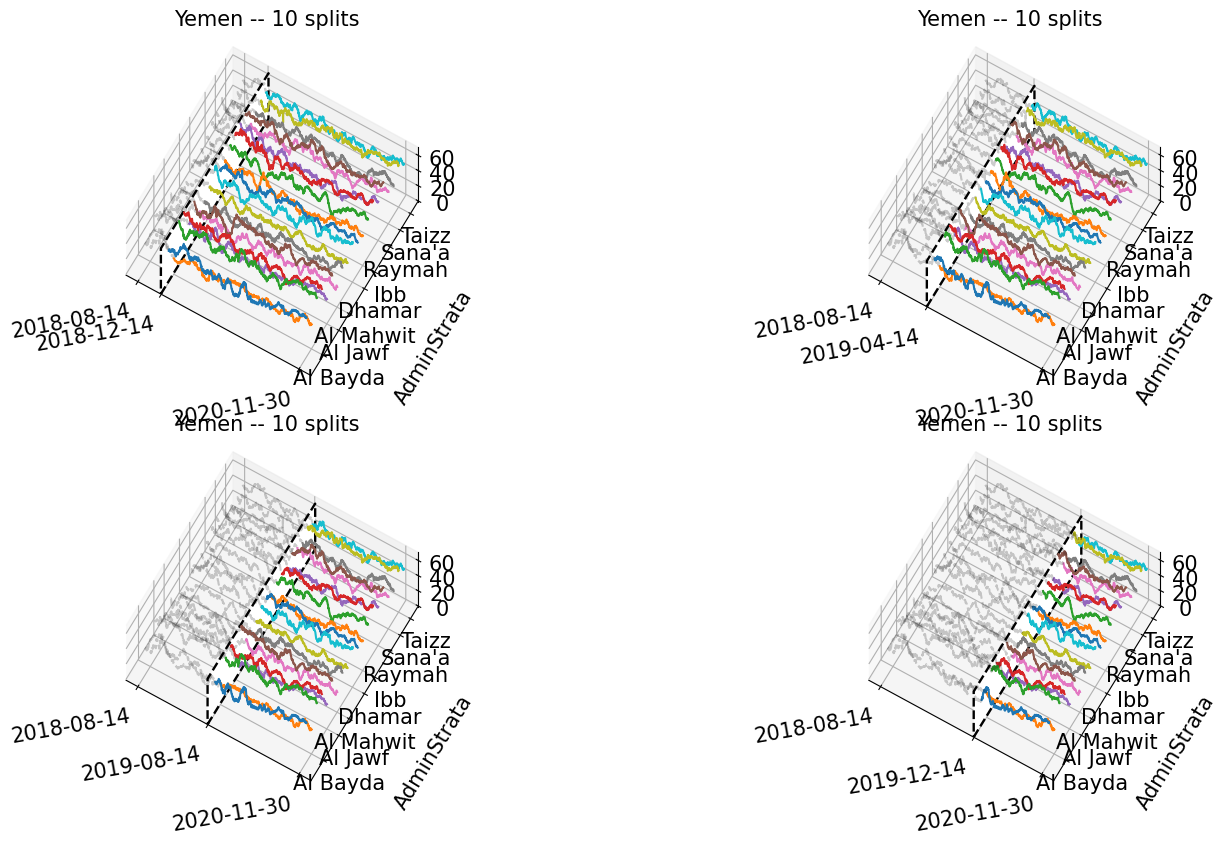

In [7]:
START_list = ["2018-08-14", "2018-12-14", "2019-04-14", "2019-08-14", "2019-12-14"]

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (20, 10), subplot_kw = dict(projection = "3d",  proj_type = "ortho"))
fig.subplots_adjust(hspace = .11, wspace = -.08)
axs = axs.ravel()

START1 = "2018-08-14"
for ii, date in enumerate(START_list[1:]):  
    START2 = date

    ax = axs[ii]
    #ax = fig.add_subplot(111, projection = "3d", proj_type = "ortho")
    
    # NOT COLORED TIME-SERIES.
    fcs1 = fcs.loc[START1:START2]

    for i, column in enumerate(fcs1.columns):
        ax.plot(np.arange(len(fcs1)), fcs1[column].values, zs = i+1, zdir = "y", 
                zorder = (len(fcs1) - i + 1), alpha = 0.2, color = "k", linestyle = "--")

    # COLORED TIME-SERIES.
    fcs2 = fcs.loc[START2:]
    
    for i, column in enumerate(fcs2.columns):
        ax.plot(np.arange(len(fcs1), len(fcs1) + len(fcs2)), fcs2[column].values, zs = i+1, zdir = "y", 
                zorder = (len(fcs2) - i + 1), alpha = 1)

    def mjrFormatter1(x, pos):
        return fcs.index.strftime("%Y-%m-%d")[int(x)]
    
    def mjrFormatter2(x, pos):
        return fcs.columns.get_level_values("AdminStrata")[int(x)]
  
    # 2D PLANE.
    ys = np.linspace(-0.5, 20.5, 2)
    zs = np.linspace(0, 60, 2)

    Y, Z = np.meshgrid(ys, zs)
    X = [fcs.index.get_loc(date)]*len(Y)
    ax.plot_surface(X, Y, Z, edgecolor = "k", alpha = 1, linewidth = 1.7, linestyle = "--", 
                    color = "w", shade = False)

    ax.view_init(70, -60)
    #ax.set_xlabel("Datetime", rotation = 0, labelpad = 40)
    ax.set_ylabel("AdminStrata", rotation = 0, labelpad = 30)
    ax.set_ylim(0, 20)
    
    xs = set([0, len(fcs)-1, int(fcs.index.get_loc(date))])

    ax.set_xticks(sorted(xs))
    ax.set_yticks([2, 5, 7, 10, 12, 15, 17, 19])
    ax.set_zticks([0, 20, 40, 60])
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter1))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter2))
    plt.setp(ax.get_xticklabels(), rotation = 10, ha = "right", rotation_mode = "anchor")
    plt.yticks(rotation = 0)
    ax.dist = 11    
    ax.set_title(f"Yemen -- 10 splits", fontdict = dict(size = 15)) 
    
# Save the figure.
fig.savefig(f"./IMAGES/Review/Figure2b.png", dpi = 300, bbox_inches = "tight")

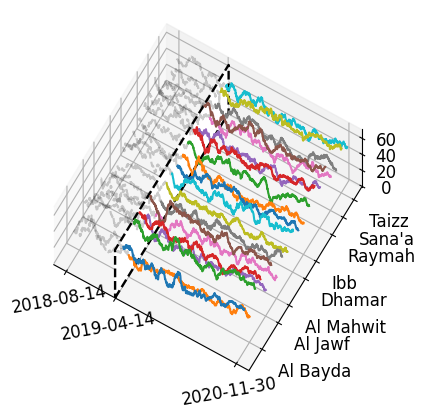

In [8]:
START_list = ["2019-04-14"]

fig, ax = plt.subplots(figsize = (9, 5), subplot_kw = dict(projection = "3d",  proj_type = "ortho"))

START1 = "2018-08-14"
for ii, date in enumerate(START_list):  
    START2 = date

    # NOT COLORED TIME-SERIES.
    fcs1 = fcs.loc[START1:START2]

    for i, column in enumerate(fcs1.columns):
        ax.plot(np.arange(len(fcs1)), fcs1[column].values, zs = i+1, zdir = "y", 
                zorder = (len(fcs1) - i + 1), alpha = 0.2, color = "k", linestyle = "--")

    # COLORED TIME-SERIES.
    fcs2 = fcs.loc[START2:]
    
    for i, column in enumerate(fcs2.columns):
        ax.plot(np.arange(len(fcs1), len(fcs1) + len(fcs2)), fcs2[column].values, zs = i+1, zdir = "y", 
                zorder = (len(fcs2) - i + 1), alpha = 1)

    def mjrFormatter1(x, pos):
        return fcs.index.strftime("%Y-%m-%d")[int(x)]
    
    def mjrFormatter2(x, pos):
        return fcs.columns.get_level_values("AdminStrata")[int(x)]
  
    # 2D PLANE.
    ys = np.linspace(-0.5, 20.5, 2)
    zs = np.linspace(0, 60, 2)

    Y, Z = np.meshgrid(ys, zs)
    X = [fcs.index.get_loc(date)]*len(Y)
    ax.plot_surface(X, Y, Z, edgecolor = "k", alpha = 1, linewidth = 1.7, linestyle = "--", 
                    color = "w", shade = False)

    ax.view_init(70, -60)
    #ax.set_xlabel("Datetime", rotation = 0, labelpad = 40)
    #ax.set_ylabel("AdminStrata", rotation = 0, labelpad = 30)
    ax.set_ylim(0, 20)
    
    xs = set([0, len(fcs)-1, int(fcs.index.get_loc(date))])

    ax.set_xticks(sorted(xs))
    ax.set_yticks([2, 5, 7, 10, 12, 15, 17, 19])
    ax.set_zticks([0, 20, 40, 60])
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter1))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter2))
    plt.setp(ax.get_xticklabels(), rotation = 10, ha = "center", rotation_mode = "anchor", fontsize = 12)
    plt.setp(ax.get_yticklabels(), rotation = 10, ha = "left", rotation_mode = "anchor", fontsize = 12)
    plt.yticks(rotation = 0)
    plt.setp(ax.get_zticklabels(), fontsize = 12)
    ax.dist = 11 
    
# Save the figure.
fig.savefig(f"./IMAGES/Review/Figure2c.png", dpi = 300, bbox_inches = "tight")